# Written on 2024.05.25

This notebook is used to perform the performance test on the trained model in each fold using the testing data extracted from the original dataset.

Since the trained models per folds have been exported previously, such models will be imported here to obtain the ROC curve, its AUC and all the associated metrics to evaluate the assessment of the model.

In [1]:
!pip install pyyaml h5py

In [2]:
# Filesystem
import os
import zipfile

# data processing
import numpy as np
import pandas as pd

# AI-related
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
import itertools
#library for cross validation
from sklearn.model_selection import StratifiedKFold

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

#EEGNET
#from EEGModels import EEGNet
#from tensorflow.keras import utils as np_utils
#from tensorflow.keras.callbacks import ModelCheckpoint
#from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras import backend as K


## 1.1 Function to plot Confusion Matrix

In [3]:
def plot_confusion_matrix (cm,
                           classes,
                           normalize = False,
                           title = 'Confusion Matrix',
                           cmap=plt.cm.Greens
                          ):
  plt.imshow (cm, interpolation='nearest', cmap=cmap)
  plt.title (title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm=cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")
  print(cm)

  thresh = cm.max()*0.80
  plt.figure()
  for i, j in itertools.product (range(cm.shape[0]), range(cm.shape[1])):
     plt.text(j, i, round(cm[i,j],2),
              horizontalalignment="center",
              color="white" if cm [i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')

## 1.3 Function to normalize EEG data (run inside the loop to assemble the tensor)

In [4]:
def normalize_channels (data, n_channels):
  data_norm = np.zeros_like(data, dtype='float32')
  for ch in range (n_channels):
      min_val = (np.min(data[ch]))
      max_val = (np.max(data[ch]))
      data_norm [ch] = (data[ch] - min_val) / (max_val - min_val)

  return data_norm

Figure to display the plots

# 2. Load data

## 2.1 Unzip testing dataset

In [5]:
local_zip = "/content/ERP_Pretest_Data_128Hz.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/content/ERP_Pretest_Data_128_Hz")
zip_ref.close()

## 2.2 Define file path

In [6]:
data_path = "/content/ERP_Pretest_Data_128_Hz/Test/"

## 2.3 Load file list

In [7]:
testlist = open  ("/content/ERP_Pretest_Data_128_Hz/TestFileList.txt", "r")
data = testlist.read()
test_data_files = data.split("\n")

In [8]:
test_data_files

['/content/ERP_Pretest_Data_128_Hz/Test/AMT002_PT_proc_tr_01.csv',
 '/content/ERP_Pretest_Data_128_Hz/Test/AMT002_PT_proc_tr_06.csv',
 '/content/ERP_Pretest_Data_128_Hz/Test/AMT002_PT_proc_tr_12.csv',
 '/content/ERP_Pretest_Data_128_Hz/Test/AMT002_PT_proc_tr_19.csv',
 '/content/ERP_Pretest_Data_128_Hz/Test/AMT002_PT_proc_tr_26.csv',
 '/content/ERP_Pretest_Data_128_Hz/Test/AMT002_PT_proc_tr_31.csv',
 '/content/ERP_Pretest_Data_128_Hz/Test/AMT002_PT_proc_tr_36.csv',
 '/content/ERP_Pretest_Data_128_Hz/Test/AMT002_PT_proc_tr_43.csv',
 '/content/ERP_Pretest_Data_128_Hz/Test/AMT002_PT_proc_tr_48.csv',
 '/content/ERP_Pretest_Data_128_Hz/Test/AMT002_PT_proc_tr_55.csv',
 '/content/ERP_Pretest_Data_128_Hz/Test/AMT002_PT_proc_tr_60.csv',
 '/content/ERP_Pretest_Data_128_Hz/Test/AMT003_PT_proc_tr_05.csv',
 '/content/ERP_Pretest_Data_128_Hz/Test/AMT003_PT_proc_tr_10.csv',
 '/content/ERP_Pretest_Data_128_Hz/Test/AMT003_PT_proc_tr_15.csv',
 '/content/ERP_Pretest_Data_128_Hz/Test/AMT003_PT_proc_tr_20.c

## 2.4 Determine the number of trials available based on the number of files

In [9]:
n_trials_test = len(test_data_files)

# 2.5 Information from the trials.

In [10]:
n_channels = 20
n_samples = 128
n_kernels = 1

# 2.6 Load data as 2D trials

In [11]:
test_set_2D = np.zeros ((n_trials_test,n_channels*n_samples), dtype='float32')

In [12]:
trial = 0
for filename in test_data_files:
  data = pd.read_csv(filename, header=None, dtype=np.float32)
  trl = np.reshape (np.array(data), (n_channels*n_samples))
  test_set_2D[trial:] = trl
  trial=trial+1

# 2.7 Load test data labels

In [14]:
test_labels_path = '/content/ERP_Pretest_Data_128_Hz/TestLabels.csv'
test_labels = np.array(pd.read_csv(test_labels_path, header=None, dtype='uint8'))
test_labels = np.squeeze(test_labels.T)

# 2.8 Balance with Random Oversampler

In [15]:
oversampler_test = RandomOverSampler(sampling_strategy='minority')
testdata_over, testlabel_over = oversampler_test.fit_resample(test_set_2D, test_labels)
(overTrials_ts,overSamples_ts) = testdata_over.shape

# 2.9 Load trials in container

In [16]:
X_test = np.zeros((overTrials_ts,n_channels,n_samples), dtype=np.float32)

In [17]:
for i in range(overTrials_ts):
  trl_rs = np.reshape (testdata_over[i],(n_channels,n_samples))
  # Optional operation to check if this improves the model performance
  trl_rs = normalize_channels(np.array(trl_rs, dtype='float32'), n_channels)
  X_test[i] = trl_rs

# reasign the training labels
y_test = testlabel_over
print(y_test.shape)

(350,)


# 3 Load Models

# 3.1 Unzip model folder

In [18]:
local_zip = "/content/DeepConvNet_Models.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/content/DeepConvNet_Models")
zip_ref.close()

## 3.2 Define file path

In [19]:
data_path = "/content/DeepConvNet_Models/"

## 3.3 Load file list

In [25]:
modellist = open  ("/content/DeepConvNet_Models/ModelsList.txt", "r")
models = modellist.read()
model_files = models.split("\n")

In [26]:
model_files

['/content/DeepConvNet_Models/DeepConvNet_model_fold_0.h5',
 '/content/DeepConvNet_Models/DeepConvNet_model_fold_1.h5',
 '/content/DeepConvNet_Models/DeepConvNet_model_fold_2.h5',
 '/content/DeepConvNet_Models/DeepConvNet_model_fold_3.h5',
 '/content/DeepConvNet_Models/DeepConvNet_model_fold_4.h5',
 '/content/DeepConvNet_Models/DeepConvNet_model_fold_5.h5',
 '/content/DeepConvNet_Models/DeepConvNet_model_fold_6.h5',
 '/content/DeepConvNet_Models/DeepConvNet_model_fold_7.h5',
 '/content/DeepConvNet_Models/DeepConvNet_model_fold_8.h5',
 '/content/DeepConvNet_Models/DeepConvNet_model_fold_9.h5']

# 4 ROC test

4.1 Import libraries for ROC curve assessment

In [27]:
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, roc_curve, auc

4.2 Iterate across all folds and generate plots and metrics

11/11 [==============================] - 0s 16ms/step
Confusion Matrix for Fold 0:
[[157  18]
 [136  39]]
11/11 [==============================] - 0s 15ms/step
Confusion Matrix for Fold 1:
[[153  22]
 [142  33]]
11/11 [==============================] - 0s 22ms/step
Confusion Matrix for Fold 2:
[[155  20]
 [147  28]]
11/11 [==============================] - 0s 27ms/step
Confusion Matrix for Fold 3:
[[150  25]
 [136  39]]
11/11 [==============================] - 0s 27ms/step
Confusion Matrix for Fold 4:
[[157  18]
 [144  31]]
11/11 [==============================] - 0s 16ms/step
Confusion Matrix for Fold 5:
[[139  36]
 [116  59]]
11/11 [==============================] - 1s 17ms/step
Confusion Matrix for Fold 6:
[[154  21]
 [141  34]]
11/11 [==============================] - 0s 15ms/step
Confusion Matrix for Fold 7:
[[152  23]
 [141  34]]
11/11 [==============================] - 0s 16ms/step
Confusion Matrix for Fold 8:
[[153  22]
 [136  39]]
11/11 [==============================] - 0s 18

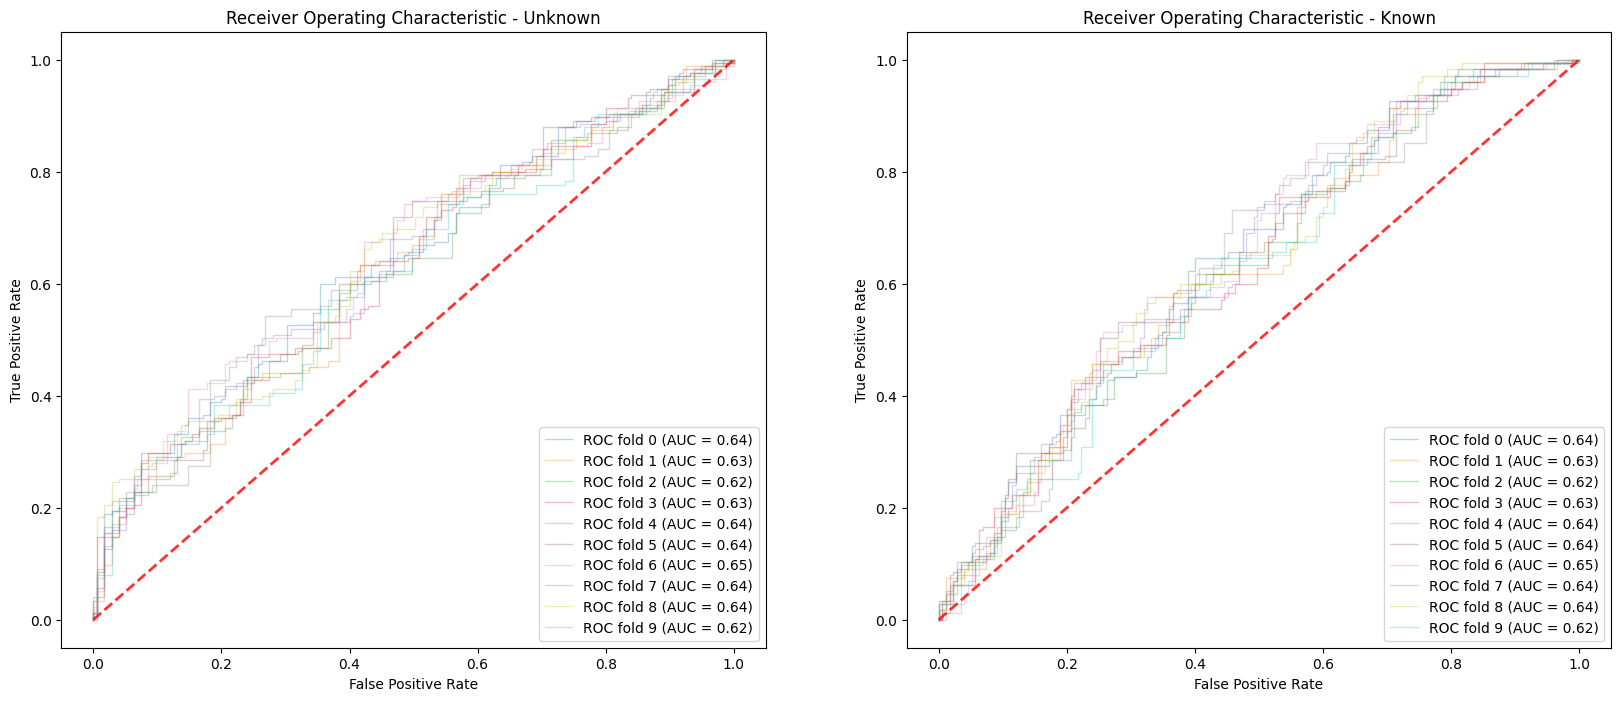

Unknown
Precision: 0.5256186332803544 ± 0.008828034670284996
Recall: 0.8662857142857142 ± 0.029823973373028324
ROC AUC Unknown: 0.6345306122448979 ± 0.009878554848637684


Known
Precision: 0.6187381587027033 ± 0.02711770270563844
Recall: 0.21714285714285714 ± 0.04732863826479693
ROC AUC: 0.6345697959183674 ± 0.009880667951460267


In [30]:
# import library for loading models from filesystem
from tensorflow.keras.models import load_model

# accuracies = []

# data containers for unknown class
precisions_unknown = []
recalls_unknown = []
specificities_unknown = []

roc_aucs_unknown = []
tprs_unknown = []
#mean_fpr_unknown = np.linspace(0, 1, 100)

# data containers for known class
precisions_known = []
recalls_known = []
specificities_known = []

roc_aucs_known = []
tprs_known = []
#mean_fpr_known = np.linspace(0, 1, 100)

fold = 0
n_folds = 10

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

for filename in model_files:

  #import model into the loop
  DeepConvNet_Model = load_model (filename)

  # perform predictions on the testing data
  y_probs       = DeepConvNet_Model.predict(X_test)
  y_probs_unknown = y_probs[:, 0]
  y_probs_known = y_probs[:, 1]
  y_preds       = y_probs.argmax(axis = -1)
  acc         = np.mean(y_preds == y_test.argmax(axis=-1))

  # General Metrics
  #accuracies.append(EEGNET_Model.score(X_test, y_test))
  #precisions.append(precision_score(y_test, y_preds, average='macro'))
  #ecalls.append(recall_score(y_test, y_preds, average='macro'))
  #1_scores.append(f1_score(y_test, y_preds, average='macro'))

  # ROC curve for Know class
  #RocCurveDisplay.from_estimator(
  #      EEGNET_Model,
  #     X_test,
  #      y_test,
  #      name=f"ROC fold {fold} Known",
  #      alpha=0.3,
  #      lw=1,
  #      ax=ax[0],
  #      plot_chance_level=(fold == fold - 1)
  #)

  # ROC curve for Unknown class
  fpr_u, tpr_u, _ = roc_curve(y_test, y_probs_unknown, pos_label=0)
  roc_auc_unknown = auc(fpr_u, tpr_u)
  roc_aucs_unknown.append(roc_auc_unknown)
  ax[0].plot(fpr_u, tpr_u, lw=1, alpha=0.3, label=f"ROC fold {fold} (AUC = {roc_auc_unknown:.2f})")

  # ROC curve for Known class
  fpr_k, tpr_k, _ = roc_curve(y_test, y_probs_known, pos_label=1)
  roc_auc_known = auc(fpr_k, tpr_k)
  roc_aucs_known.append(roc_auc_known)
  ax[1].plot(fpr_k, tpr_k, lw=1, alpha=0.3, label=f"ROC fold {fold} (AUC = {roc_auc_known:.2f})")

  # Confusion matrix for the current fold
  print(f'Confusion Matrix for Fold {fold}:')
  cm = confusion_matrix((y_test), y_preds)
  print(cm)
  #cm_plot_labels = ['Unknown', 'Known']
  #plot_confusion_matrix(cm, cm_plot_labels, normalize=False, title='Confusion Matrix')

  # Overall accuracy
  # accuracies.append (acc)

  # values from confusion matrix

  # Unknown Class
  tp_U = cm [0,0]
  tn_U = cm [1,1]
  fp_U = cm [1,0]
  fn_U = cm [0,1]

  prec_unknown = tp_U / (tp_U + fp_U)
  precisions_unknown.append (prec_unknown)

  rec_unknown = tp_U / (tp_U + fn_U)  #AKA sensitivity
  recalls_unknown.append (rec_unknown)

  specificity_unknown = tn_U / (tn_U + fp_U)
  specificities_unknown.append (specificity_unknown)

  # Known Class
  tp_K = cm [1,1]
  tn_K = cm [0,0]
  fp_K = cm [0,1]
  fn_K = cm [1,0]

  prec_known = tp_K / (tp_K + fp_K)
  precisions_known.append (prec_known)

  rec_known = tp_K / (tp_K + fn_K)  #AKA sensitivity
  recalls_known.append (rec_known)

  specificity_known = tn_K / (tn_K + fp_K)
  specificities_known.append (specificity_known)


  fold = fold+1



#plot everything
ax[0].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('Receiver Operating Characteristic - Unknown')
ax[0].legend(loc='lower right')

ax[1].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic - Known')
ax[1].legend(loc='lower right')

plt.show()
# print(f'Accuracy: {np.mean(accuracies)} ± {np.std(accuracies)}')

print('Unknown')
print(f'Precision: {np.mean(precisions_unknown)} ± {np.std(precisions_unknown)}')
print(f'Recall: {np.mean(recalls_unknown)} ± {np.std(recalls_unknown)}')
#print(f'F1-Score Unknown: {np.mean(f1_scores_unknown)} ± {np.std(f1_scores_unknown)}')
print(f'ROC AUC Unknown: {np.mean(roc_aucs_unknown)} ± {np.std(roc_aucs_unknown)}')
print('\n')
print('Known')
print(f'Precision: {np.mean(precisions_known)} ± {np.std(precisions_known)}')
print(f'Recall: {np.mean(recalls_known)} ± {np.std(recalls_known)}')
#print(f'F1-Score: {np.mean(f1_scores_known)} ± {np.std(f1_scores_known)}')
print(f'ROC AUC: {np.mean(roc_aucs_known)} ± {np.std(roc_aucs_known)}')


In [31]:
outputfile = '/content/DeepConvNet_ROC_Summary.csv'
df = pd.DataFrame({'Unknown_AOC':roc_aucs_unknown,
                   'Unknown_Precission': precisions_unknown,
                   'Unknown Recall': recalls_unknown,
                   'Unknown Specificity': specificities_unknown,
                   'Known_AOC': roc_aucs_known,
                   'Known_Precission': precisions_known,
                   'Known Recall': recalls_known,
                   'Known Specificity': specificities_known,
                   })
df.to_csv(outputfile)